# AI Text Detection - Heuristic Models

This notebook trains multiple machine learning models to detect AI-generated text using heuristic features.


In [78]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [79]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (269, 4)
Test shape: (264, 3)


## Feature Engineering Functions


In [80]:
def extract_text_features(df):
    """
    Extract comprehensive text-based features from the answer column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'answer' column
        
    Returns:
    -------
    pd.DataFrame
        DataFrame with additional feature columns
    """
    df = df.copy()
    
    # Basic text statistics
    df['text_length'] = df['answer'].str.len()
    df['word_count'] = df['answer'].str.split().str.len()
    df['char_count_no_spaces'] = df['answer'].str.replace(' ', '').str.len()
    df['sentence_count'] = df['answer'].str.count(r'[.!?]+')
    df['paragraph_count'] = df['answer'].str.count('\n\n') + 1
    
    # Average word length
    df['avg_word_length'] = df['char_count_no_spaces'] / (df['word_count'] + 1e-6)
    
    # Average sentence length
    df['avg_sentence_length'] = df['word_count'] / (df['sentence_count'] + 1e-6)
    
    # Punctuation features (escaping special regex characters)
    df['exclamation_count'] = df['answer'].str.count('!')
    df['question_count'] = df['answer'].str.count(r'\?')
    df['comma_count'] = df['answer'].str.count(',')
    df['period_count'] = df['answer'].str.count(r'\.')
    df['punctuation_ratio'] = (df['exclamation_count'] + df['question_count'] + df['period_count']) / (df['text_length'] + 1e-6)
    
    # Capitalization features
    df['uppercase_count'] = df['answer'].str.findall(r'[A-Z]').str.len()
    df['uppercase_ratio'] = df['uppercase_count'] / (df['text_length'] + 1e-6)
    
    # Special characters
    df['digit_count'] = df['answer'].str.count(r'\d')
    df['special_char_count'] = df['answer'].str.count(r'[^\w\s]')
    
    # Word complexity (long words)
    words = df['answer'].str.split()
    df['long_word_count'] = words.apply(lambda x: sum(1 for w in x if len(w) > 6))
    df['long_word_ratio'] = df['long_word_count'] / (df['word_count'] + 1e-6)
    
    # Common AI indicators (case-insensitive using findall)
    df['first_person_pronouns'] = df['answer'].str.findall(r'(?i)\b(I|me|my|myself|we|us|our|ourselves)\b').str.len()
    df['first_person_ratio'] = df['first_person_pronouns'] / (df['word_count'] + 1e-6)
    
    # Whitespace features
    df['whitespace_count'] = df['answer'].str.count(' ')
    df['whitespace_ratio'] = df['whitespace_count'] / (df['text_length'] + 1e-6)
    
    # Unique word ratio (vocabulary diversity)
    df['unique_word_count'] = words.apply(lambda x: len(set(w.lower() for w in x)) if x else 0)
    df['unique_word_ratio'] = df['unique_word_count'] / (df['word_count'] + 1e-6)
    
    return df


In [81]:
def encode_topic(df, le=None, fit=True):
    """
    Encode topic column using LabelEncoder.
    Handles unseen topics in test set by mapping them to -1.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'topic' column
    le : LabelEncoder, optional
        Pre-fitted LabelEncoder. If None and fit=True, creates new one
    fit : bool
        Whether to fit the encoder (True for training, False for test)
        
    Returns:
    -------
    pd.DataFrame, LabelEncoder
        DataFrame with encoded topic and the encoder
    """
    df = df.copy()
    
    if le is None:
        le = LabelEncoder()
    
    if fit:
        df['topic_encoded'] = le.fit_transform(df['topic'])
    else:
        # Handle unseen topics by mapping them to -1
        known_topics = set(le.classes_)
        df['topic_encoded'] = df['topic'].apply(
            lambda x: le.transform([x])[0] if x in known_topics else -1
        )
    
    return df, le


In [82]:
def prepare_features(train_df, test_df=None):
    """
    Prepare features for training and testing.
    
    Parameters:
    -----------
    train_df : pd.DataFrame
        Training dataframe
    test_df : pd.DataFrame, optional
        Test dataframe
        
    Returns:
    -------
    tuple
        (X_train, y_train, X_test, feature_names, topic_encoder)
    """
    # Extract text features
    train_processed = extract_text_features(train_df)
    
    # Encode topics
    train_processed, topic_encoder = encode_topic(train_processed, fit=True)
    
    # Select feature columns (exclude id, topic, answer, is_cheating)
    feature_cols = [col for col in train_processed.columns 
                   if col not in ['id', 'topic', 'answer', 'is_cheating']]
    
    X_train = train_processed[feature_cols].values
    y_train = train_processed['is_cheating'].values
    
    X_test = None
    if test_df is not None:
        test_processed = extract_text_features(test_df)
        test_processed, _ = encode_topic(test_processed, le=topic_encoder, fit=False)
        X_test = test_processed[feature_cols].values
    
    return X_train, y_train, X_test, feature_cols, topic_encoder


## Model Evaluation Functions


In [83]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Evaluate model performance with multiple metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    y_pred_proba : array-like, optional
        Predicted probabilities (for ROC-AUC)
    model_name : str
        Name of the model for display
        
    Returns:
    -------
    dict
        Dictionary of metrics
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    for metric, value in metrics.items():
        print(f"{metric.upper():15s}: {value:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Authentic', 'AI-assisted']))
    
    return metrics


In [84]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model", ax=None):
    """
    Plot confusion matrix.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    model_name : str
        Name of the model
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Authentic', 'AI-assisted'],
                yticklabels=['Authentic', 'AI-assisted'])
    ax.set_title(f'{model_name} - Confusion Matrix', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    if ax is None:
        plt.tight_layout()
        plt.show()


In [85]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model", ax=None):
    """
    Plot ROC curve.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities
    model_name : str
        Name of the model
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {auc_score:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{model_name} - ROC Curve', fontweight='bold', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    
    if ax is None:
        plt.tight_layout()
        plt.show()
    
    return auc_score


In [86]:
def plot_feature_importance(model, feature_names, model_name="Model", top_n=15, ax=None):
    """
    Plot feature importance.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model with feature_importances_ attribute
    feature_names : list
        List of feature names
    model_name : str
        Name of the model
    top_n : int
        Number of top features to display
    ax : matplotlib.axes, optional
        Axes to plot on
    """
    if not hasattr(model, 'feature_importances_'):
        print(f"Model {model_name} does not have feature_importances_ attribute")
        return
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.barh(range(top_n), importances[indices], color='steelblue')
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name} - Top {top_n} Feature Importances', fontweight='bold', fontsize=12)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    if ax is None:
        plt.tight_layout()
        plt.show()


In [87]:
def cross_validate_model(model, X, y, cv=5, scoring='roc_auc'):
    """
    Perform cross-validation on a model.
    
    Parameters:
    -----------
    model : sklearn model
        Model to cross-validate
    X : array-like
        Features
    y : array-like
        Labels
    cv : int
        Number of folds
    scoring : str
        Scoring metric
        
    Returns:
    -------
    dict
        Dictionary with CV results
    """
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    results = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"\nCross-Validation Results ({scoring}):")
    print(f"Mean: {results['mean']:.4f} (+/- {results['std']*2:.4f})")
    print(f"Individual fold scores: {cv_scores}")
    
    return results


## Prepare Features


In [88]:
# Prepare features
X_train, y_train, X_test, feature_names, topic_encoder = prepare_features(train, test)

print(f"Number of features: {len(feature_names)}")
print(f"\nFeature names:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:2d}. {name}")


Number of features: 25

Feature names:
 1. text_length
 2. word_count
 3. char_count_no_spaces
 4. sentence_count
 5. paragraph_count
 6. avg_word_length
 7. avg_sentence_length
 8. exclamation_count
 9. question_count
10. comma_count
11. period_count
12. punctuation_ratio
13. uppercase_count
14. uppercase_ratio
15. digit_count
16. special_char_count
17. long_word_count
18. long_word_ratio
19. first_person_pronouns
20. first_person_ratio
21. whitespace_count
22. whitespace_ratio
23. unique_word_count
24. unique_word_ratio
25. topic_encoded


In [89]:
# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val_split.shape[0]}")
print(f"Test set size: {X_test.shape[0] if X_test is not None else 0}")


Training set size: 215
Validation set size: 54
Test set size: 264


## Train Models


In [90]:
# Dictionary to store all models and their results
models = {}
results = {}


In [91]:
# 1. Random Forest
print("\n" + "="*60)
print("Training Random Forest")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation
cv_results = cross_validate_model(rf_model, X_train_split, y_train_split, cv=5)

# Train on full training set
rf_model.fit(X_train_split, y_train_split)

# Predictions
y_pred_rf = rf_model.predict(X_val_split)
y_pred_proba_rf = rf_model.predict_proba(X_val_split)[:, 1]

# Evaluate
rf_metrics = evaluate_model(y_val_split, y_pred_rf, y_pred_proba_rf, "Random Forest")

# Store
models['Random Forest'] = rf_model
results['Random Forest'] = rf_metrics



Training Random Forest

Cross-Validation Results (roc_auc):
Mean: 0.9510 (+/- 0.0614)
Individual fold scores: [0.97391304 0.9673913  0.96086957 0.89035088 0.9627193 ]

Random Forest - Evaluation Metrics
ACCURACY       : 0.8889
PRECISION      : 0.9615
RECALL         : 0.8333
F1             : 0.8929
ROC_AUC        : 0.9201

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.82      0.96      0.88        24
 AI-assisted       0.96      0.83      0.89        30

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



In [92]:
# 2. XGBoost
print("\n" + "="*60)
print("Training XGBoost")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Cross-validation
cv_results = cross_validate_model(xgb_model, X_train_split, y_train_split, cv=5)

# Train on full training set
xgb_model.fit(X_train_split, y_train_split)

# Predictions
y_pred_xgb = xgb_model.predict(X_val_split)
y_pred_proba_xgb = xgb_model.predict_proba(X_val_split)[:, 1]

# Evaluate
xgb_metrics = evaluate_model(y_val_split, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

# Store
models['XGBoost'] = xgb_model
results['XGBoost'] = xgb_metrics



Training XGBoost

Cross-Validation Results (roc_auc):
Mean: 0.9620 (+/- 0.0572)
Individual fold scores: [0.95869565 0.98043478 0.97608696 0.90789474 0.98684211]

XGBoost - Evaluation Metrics
ACCURACY       : 0.8889
PRECISION      : 0.9615
RECALL         : 0.8333
F1             : 0.8929
ROC_AUC        : 0.9389

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.82      0.96      0.88        24
 AI-assisted       0.96      0.83      0.89        30

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



In [93]:
# 3. Logistic Regression (with scaling)
print("\n" + "="*60)
print("Training Logistic Regression")
print("="*60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)

# Cross-validation
cv_results = cross_validate_model(lr_model, X_train_scaled, y_train_split, cv=5)

# Train on full training set
lr_model.fit(X_train_scaled, y_train_split)

# Predictions
y_pred_lr = lr_model.predict(X_val_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Evaluate
lr_metrics = evaluate_model(y_val_split, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

# Store (with scaler)
models['Logistic Regression'] = {'model': lr_model, 'scaler': scaler}
results['Logistic Regression'] = lr_metrics



Training Logistic Regression

Cross-Validation Results (roc_auc):
Mean: 0.9284 (+/- 0.0520)
Individual fold scores: [0.94782609 0.93478261 0.91086957 0.88815789 0.96052632]

Logistic Regression - Evaluation Metrics
ACCURACY       : 0.8519
PRECISION      : 0.8667
RECALL         : 0.8667
F1             : 0.8667
ROC_AUC        : 0.9222

Classification Report:
              precision    recall  f1-score   support

   Authentic       0.83      0.83      0.83        24
 AI-assisted       0.87      0.87      0.87        30

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54



## Visualizations


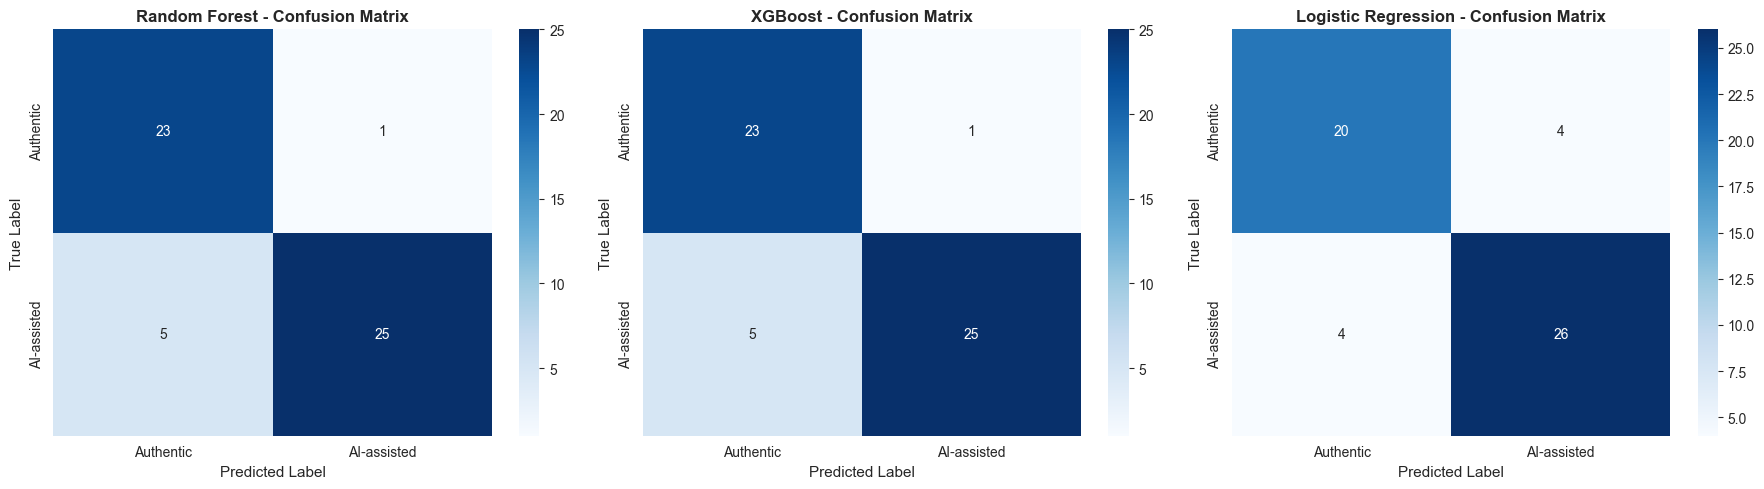

In [94]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_confusion_matrix(y_val_split, y_pred_rf, "Random Forest", ax=axes[0])
plot_confusion_matrix(y_val_split, y_pred_xgb, "XGBoost", ax=axes[1])
plot_confusion_matrix(y_val_split, y_pred_lr, "Logistic Regression", ax=axes[2])

plt.tight_layout()
plt.show()


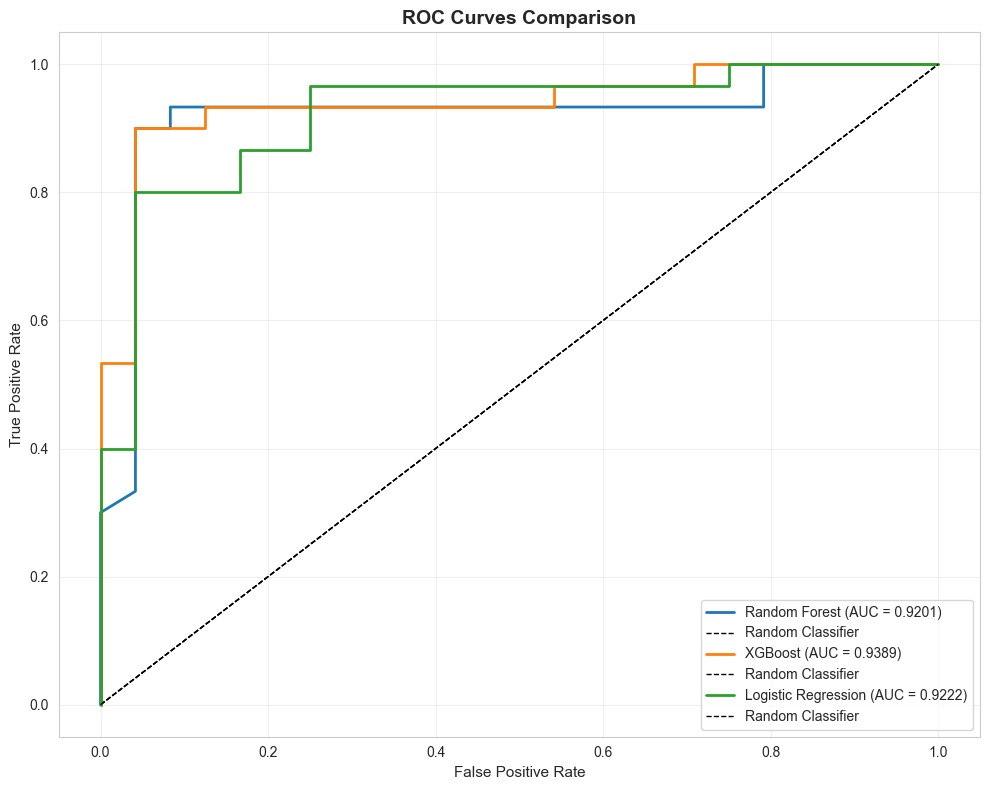

In [95]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

plot_roc_curve(y_val_split, y_pred_proba_rf, "Random Forest", ax=ax)
plot_roc_curve(y_val_split, y_pred_proba_xgb, "XGBoost", ax=ax)
plot_roc_curve(y_val_split, y_pred_proba_lr, "Logistic Regression", ax=ax)

ax.set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()


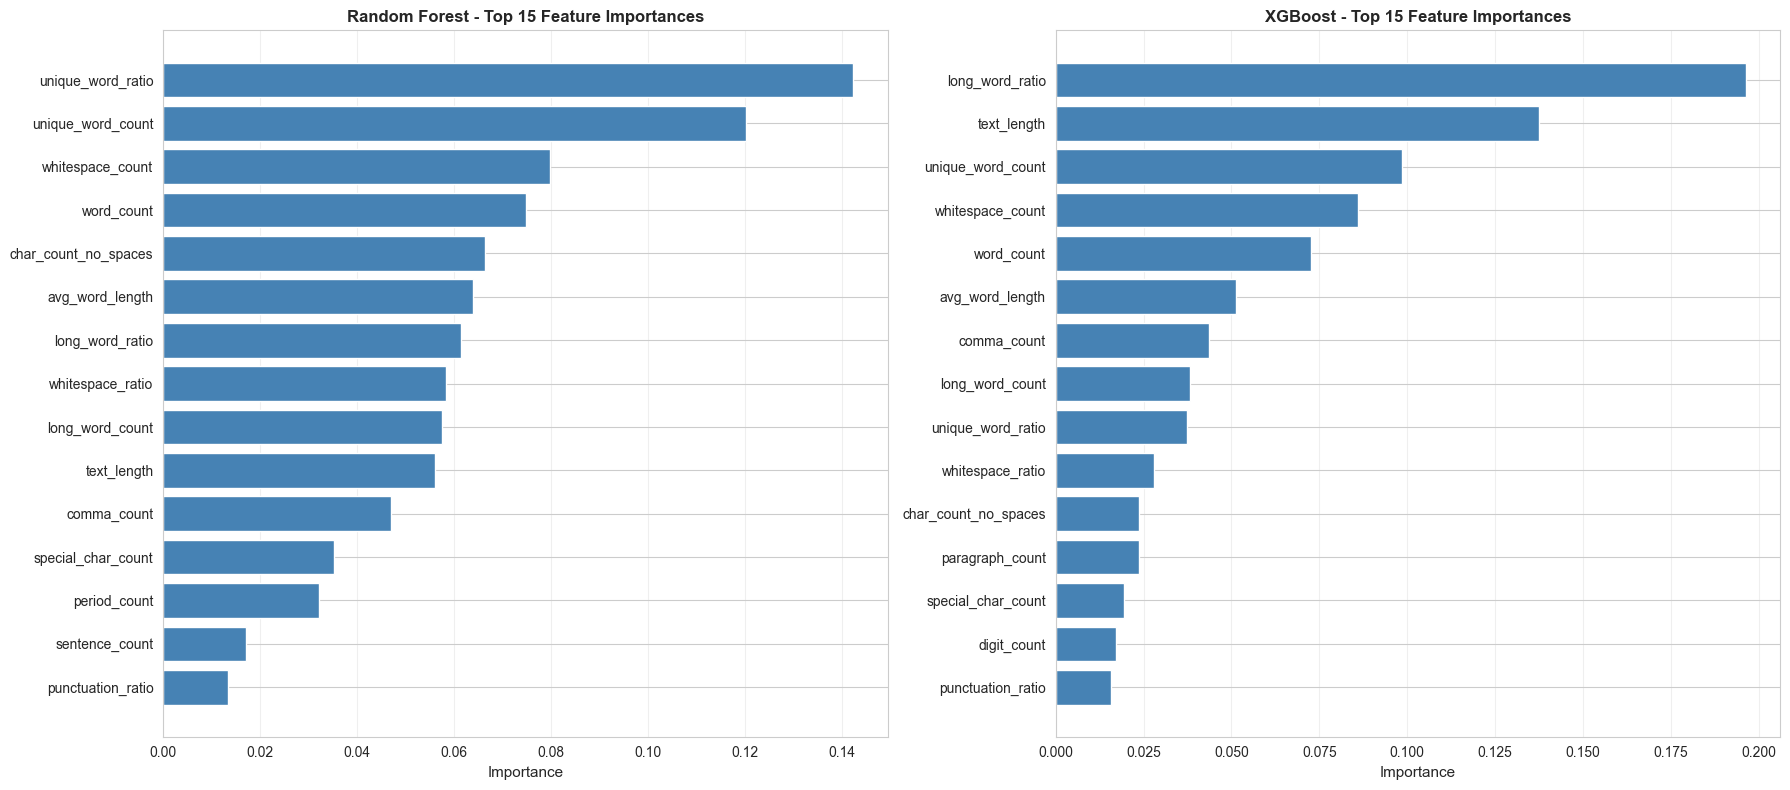

In [96]:
# Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plot_feature_importance(rf_model, feature_names, "Random Forest", top_n=15, ax=axes[0])
plot_feature_importance(xgb_model, feature_names, "XGBoost", top_n=15, ax=axes[1])

plt.tight_layout()
plt.show()



MODEL COMPARISON
                     accuracy  precision  recall      f1  roc_auc
XGBoost                0.8889     0.9615  0.8333  0.8929   0.9389
Logistic Regression    0.8519     0.8667  0.8667  0.8667   0.9222
Random Forest          0.8889     0.9615  0.8333  0.8929   0.9201


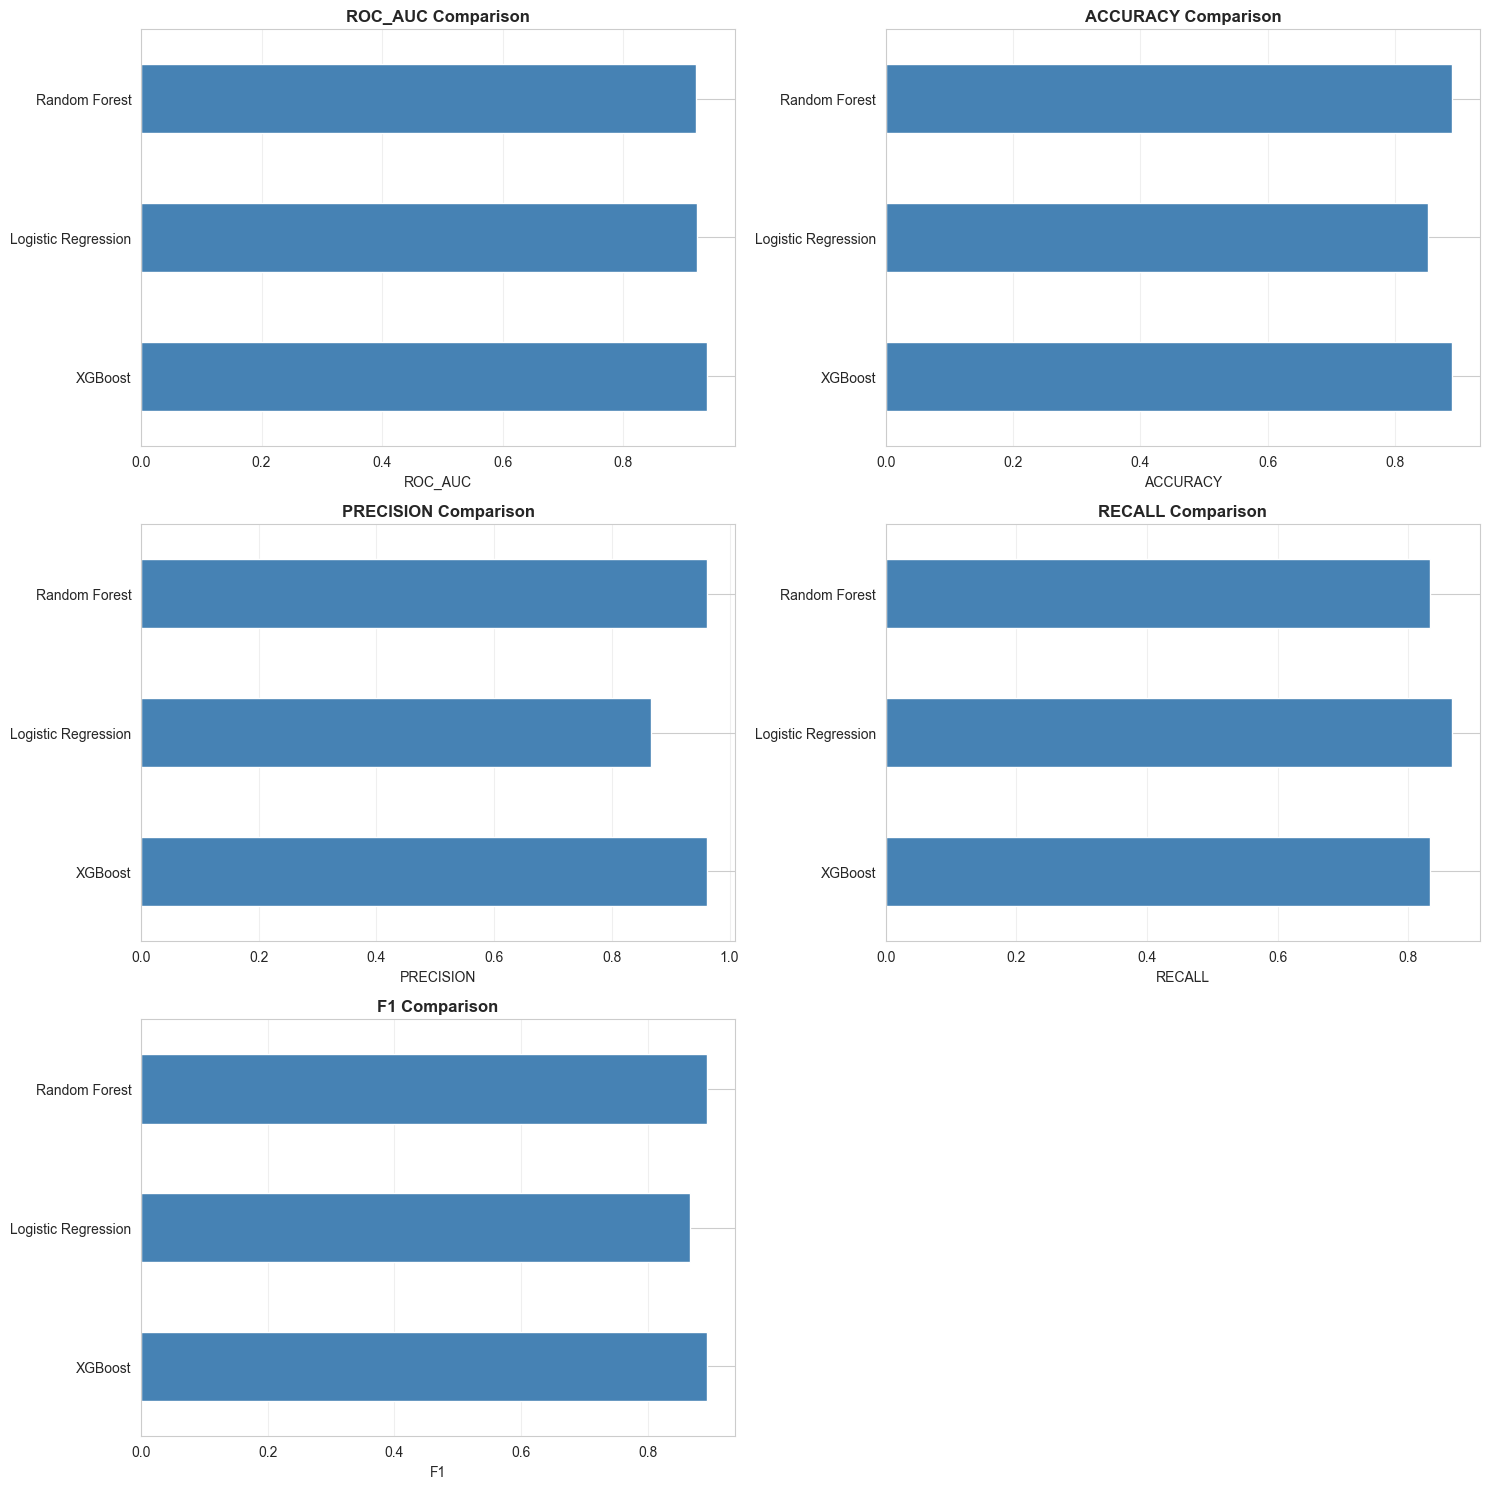

In [97]:
# Model Comparison
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('roc_auc', ascending=False)

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

metrics_to_plot = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
for i, metric in enumerate(metrics_to_plot):
    if metric in comparison_df.columns:
        ax = axes[i // 2, i % 2]
        comparison_df[metric].plot(kind='barh', ax=ax, color='steelblue')
        ax.set_title(f'{metric.upper()} Comparison', fontweight='bold')
        ax.set_xlabel(metric.upper())
        ax.grid(axis='x', alpha=0.3)

# Hide the last empty subplot if we have odd number of metrics
if len([m for m in metrics_to_plot if m in comparison_df.columns]) < 6:
    axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


## Generate Predictions on Test Set


In [98]:
# Train best model on full training data
best_model_name = comparison_df.index[0]
print(f"Best model: {best_model_name}")
print(f"ROC-AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

# Retrain best model on full training set
if best_model_name == 'Logistic Regression':
    scaler_full = StandardScaler()
    X_train_full_scaled = scaler_full.fit_transform(X_train)
    X_test_scaled = scaler_full.transform(X_test)
    
    best_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
    best_model.fit(X_train_full_scaled, y_train)
    test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]
elif best_model_name == 'XGBoost':
    best_model = xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    )
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict_proba(X_test)[:, 1]
else:  # Random Forest
    best_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    test_predictions = best_model.predict_proba(X_test)[:, 1]

print(f"\nGenerated predictions for {len(test_predictions)} test samples")


Best model: XGBoost
ROC-AUC: 0.9389

Generated predictions for 264 test samples


In [99]:
# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'is_cheating': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['is_cheating'].describe())


Submission file saved as 'submission.csv'

Submission preview:
                 id  is_cheating
0  scr_81822029c661     0.426982
1  scr_52efb19e0ea9     0.992273
2  scr_8fc0f33c559e     0.252559
3  scr_bac3f5d3aa12     0.267407
4  scr_adfbe009984d     0.053054
5  scr_9e08ece19277     0.992095
6  scr_0e34514f3cd4     0.998305
7  scr_b10d808b5528     0.997003
8  scr_2024f1e7bf94     0.834662
9  scr_aa0b11f10fff     0.061381

Prediction statistics:
count    264.000000
mean       0.595356
std        0.426196
min        0.005186
25%        0.083827
50%        0.896884
75%        0.995844
max        0.999011
Name: is_cheating, dtype: float64
